# Report on Reverse Engineering the Mechanism of Wechat Red Envelop

Zhangzhi Xiong (熊章智，202353314), Tianni Yang (杨天倪, 2023533107), Xin Zhao (赵鑫, 2023531057)

{xiongzhzh2023, yangtn2023, zhaoxin2023}@shanghaitech.edu.cn

## Abstract:

Wechat Red Envelope has been developing rapidly and has become a part of our daily life. Especially in holidays like Chinese New Years, we will be busying clicking and sending Red Envelope in Wechat. It has been a interesting topic about what is the prior distribution of the Wechat Red Envelop money for each person. In this report, we collect data so as to use tradition model like normal distribution to simulate it, and then use various methods to testify the likelihood. Then we propose a distriution model called Double Expectation. Moreover, we use diffusion model to learn the distribution and generate more data, and then check whether the generated data fit the distribution well. At last, we do some extension tasks like discussing the clicking strategy, whether distribution change in special holidays, etc.  

## 1. Introduction
We collect two datasets: one with three people, 5 yuan in total, and 100 trials; and one with four people, 5 yuan in total, and 100 trials. We also have two additional data collected on Jan 1st, 2025, with 5 yuan in total, 25 trials, three or four people respectively. First we try to use the normal distribution to do the statistics inference, and the simulation shows bad results. Therefore according to the key observations and inspiration from blogs and relative work online, we propose the Double Expectation model. Then we use various methods to testify the matching degree and likelihood. Furthermore, we use the latest adopted diffusion model to learn the hidden distribution and generate more data. These data will undergo the matching degree test as well. Finally we will further discuss some relative topics, like clicking strategy, possible factors, possible adjustment to the model to handle different requirents, etc. In a nut shell, the results and the contributions of this report are summarized as follows:
- Two Datasets and two additional datasets
- Double Expectation modeling
- Model testing on matching degree
- Usage of Diffusion model
- Further discussion and theoretical analysis

Teammates Distribution:
- Zhangzhi Xiong: Diffusion Modeling
- Tianni Yang: Double Expectation, Model Testing
- Xin Zhao: Double Expectation, Model Testing
- Joint Work: Writing, Data Collection, Further Discussion and Theoretical Analysis

## 2. Visualization of Collected Data
We use the following code to present the Histogram, Boxplots, and Scatterplot to demonstrate the two datasets. Note that partial usage of the library in python is under the assistance of Generative AI.

Original column names: ['1.69', '0.95', '2.36']


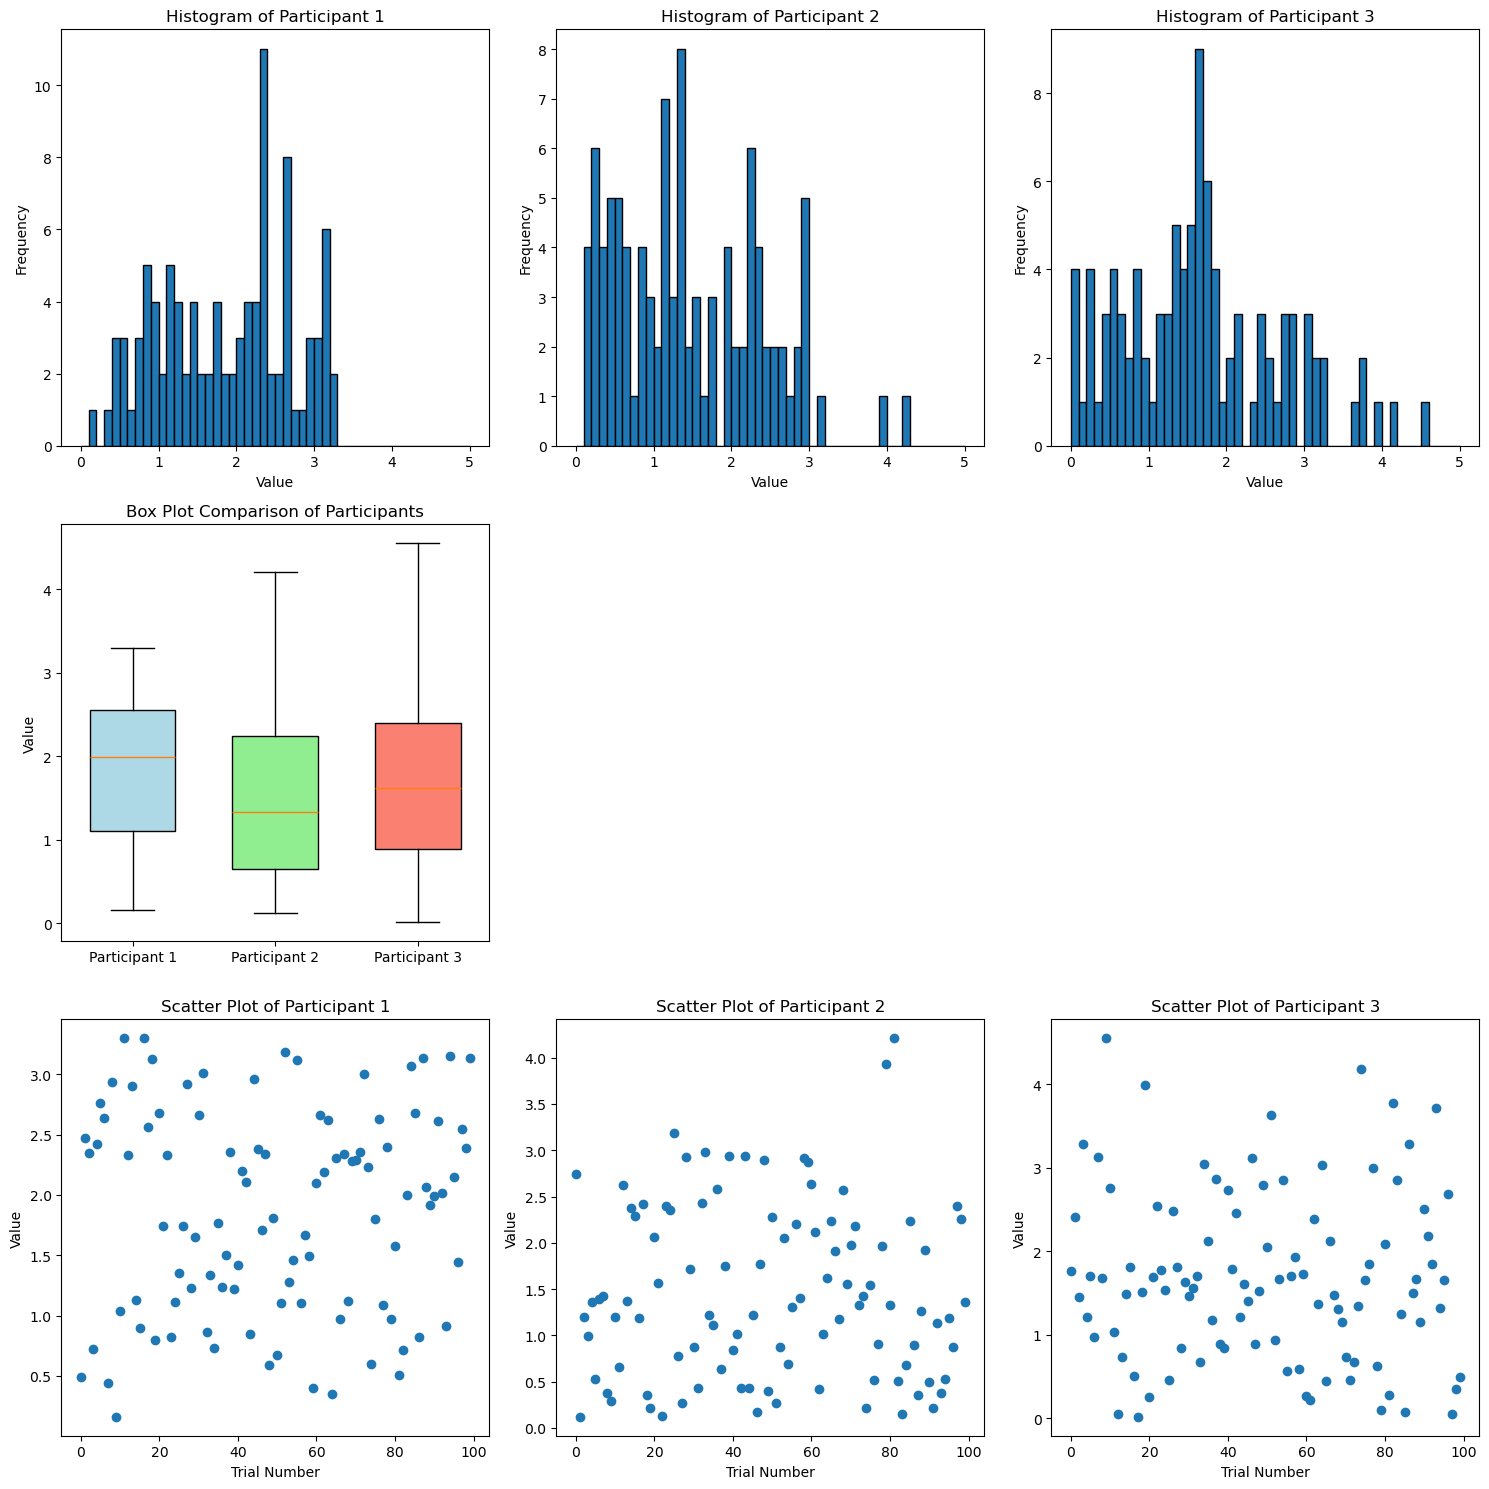

In [4]:
import pandas as pd  
import matplotlib.pyplot as plt  
import numpy as np  

# Read the CSV file  
df = pd.read_csv('data/csv/data1.csv')  # Updated file name  

# View original column names  
print("Original column names:", df.columns.tolist())  
def vis_three_people(df):
    # Rename columns for easier access  
    df.columns = ['Participant1', 'Participant2', 'Participant3']  

    # Create figures  
    plt.figure(figsize=(15, 15))  

    # Histograms with 0.1 bin width  
    plt.subplot(3, 3, 1)  
    plt.hist(df['Participant1'], bins=np.arange(0, 5.1, 0.1), edgecolor='black')  # 0.1 intervals  
    plt.title('Histogram of Participant 1')  
    plt.xlabel('Value')  
    plt.ylabel('Frequency')  

    plt.subplot(3, 3, 2)  
    plt.hist(df['Participant2'], bins=np.arange(0, 5.1, 0.1), edgecolor='black')  # 0.1 intervals  
    plt.title('Histogram of Participant 2')  
    plt.xlabel('Value')  
    plt.ylabel('Frequency')  

    plt.subplot(3, 3, 3)  
    plt.hist(df['Participant3'], bins=np.arange(0, 5.1, 0.1), edgecolor='black')  # 0.1 intervals  
    plt.title('Histogram of Participant 3')  
    plt.xlabel('Value')  
    plt.ylabel('Frequency')  

    # Box plots on the same plot with different colors  
    plt.subplot(3, 3, 4)  
    box_data = [df['Participant1'], df['Participant2'], df['Participant3']]  
    box_colors = ['lightblue', 'lightgreen', 'salmon']  
    box_positions = [1, 2, 3]  

    # Create box plots with patch_artist to allow color fill  
    box_parts = plt.boxplot(box_data, positions=box_positions, patch_artist=True, widths=0.6)  

    # Set colors for each box  
    for i, patch in enumerate(box_parts['boxes']):  
        patch.set_facecolor(box_colors[i])  # Set the face color  
        patch.set_edgecolor('black')  # Set the edge color  

    plt.title('Box Plot Comparison of Participants')  
    plt.ylabel('Value')  
    plt.xticks(box_positions, ['Participant 1', 'Participant 2', 'Participant 3'])  

    # Scatter plots  
    plt.subplot(3, 3, 7)  
    plt.scatter(range(len(df['Participant1'])), df['Participant1'])  
    plt.title('Scatter Plot of Participant 1')  
    plt.xlabel('Trial Number')  
    plt.ylabel('Value')  

    plt.subplot(3, 3, 8)  
    plt.scatter(range(len(df['Participant2'])), df['Participant2'])  
    plt.title('Scatter Plot of Participant 2')  
    plt.xlabel('Trial Number')  
    plt.ylabel('Value')  

    plt.subplot(3, 3, 9)  
    plt.scatter(range(len(df['Participant3'])), df['Participant3'])  
    plt.title('Scatter Plot of Participant 3')  
    plt.xlabel('Trial Number')  
    plt.ylabel('Value')  

    # Adjust subplot spacing  
    plt.tight_layout()  

    # Show the plots  
    plt.show()
vis_three_people(df)

Original column names: ['1.07', '0.16', '0.9', '2.87']


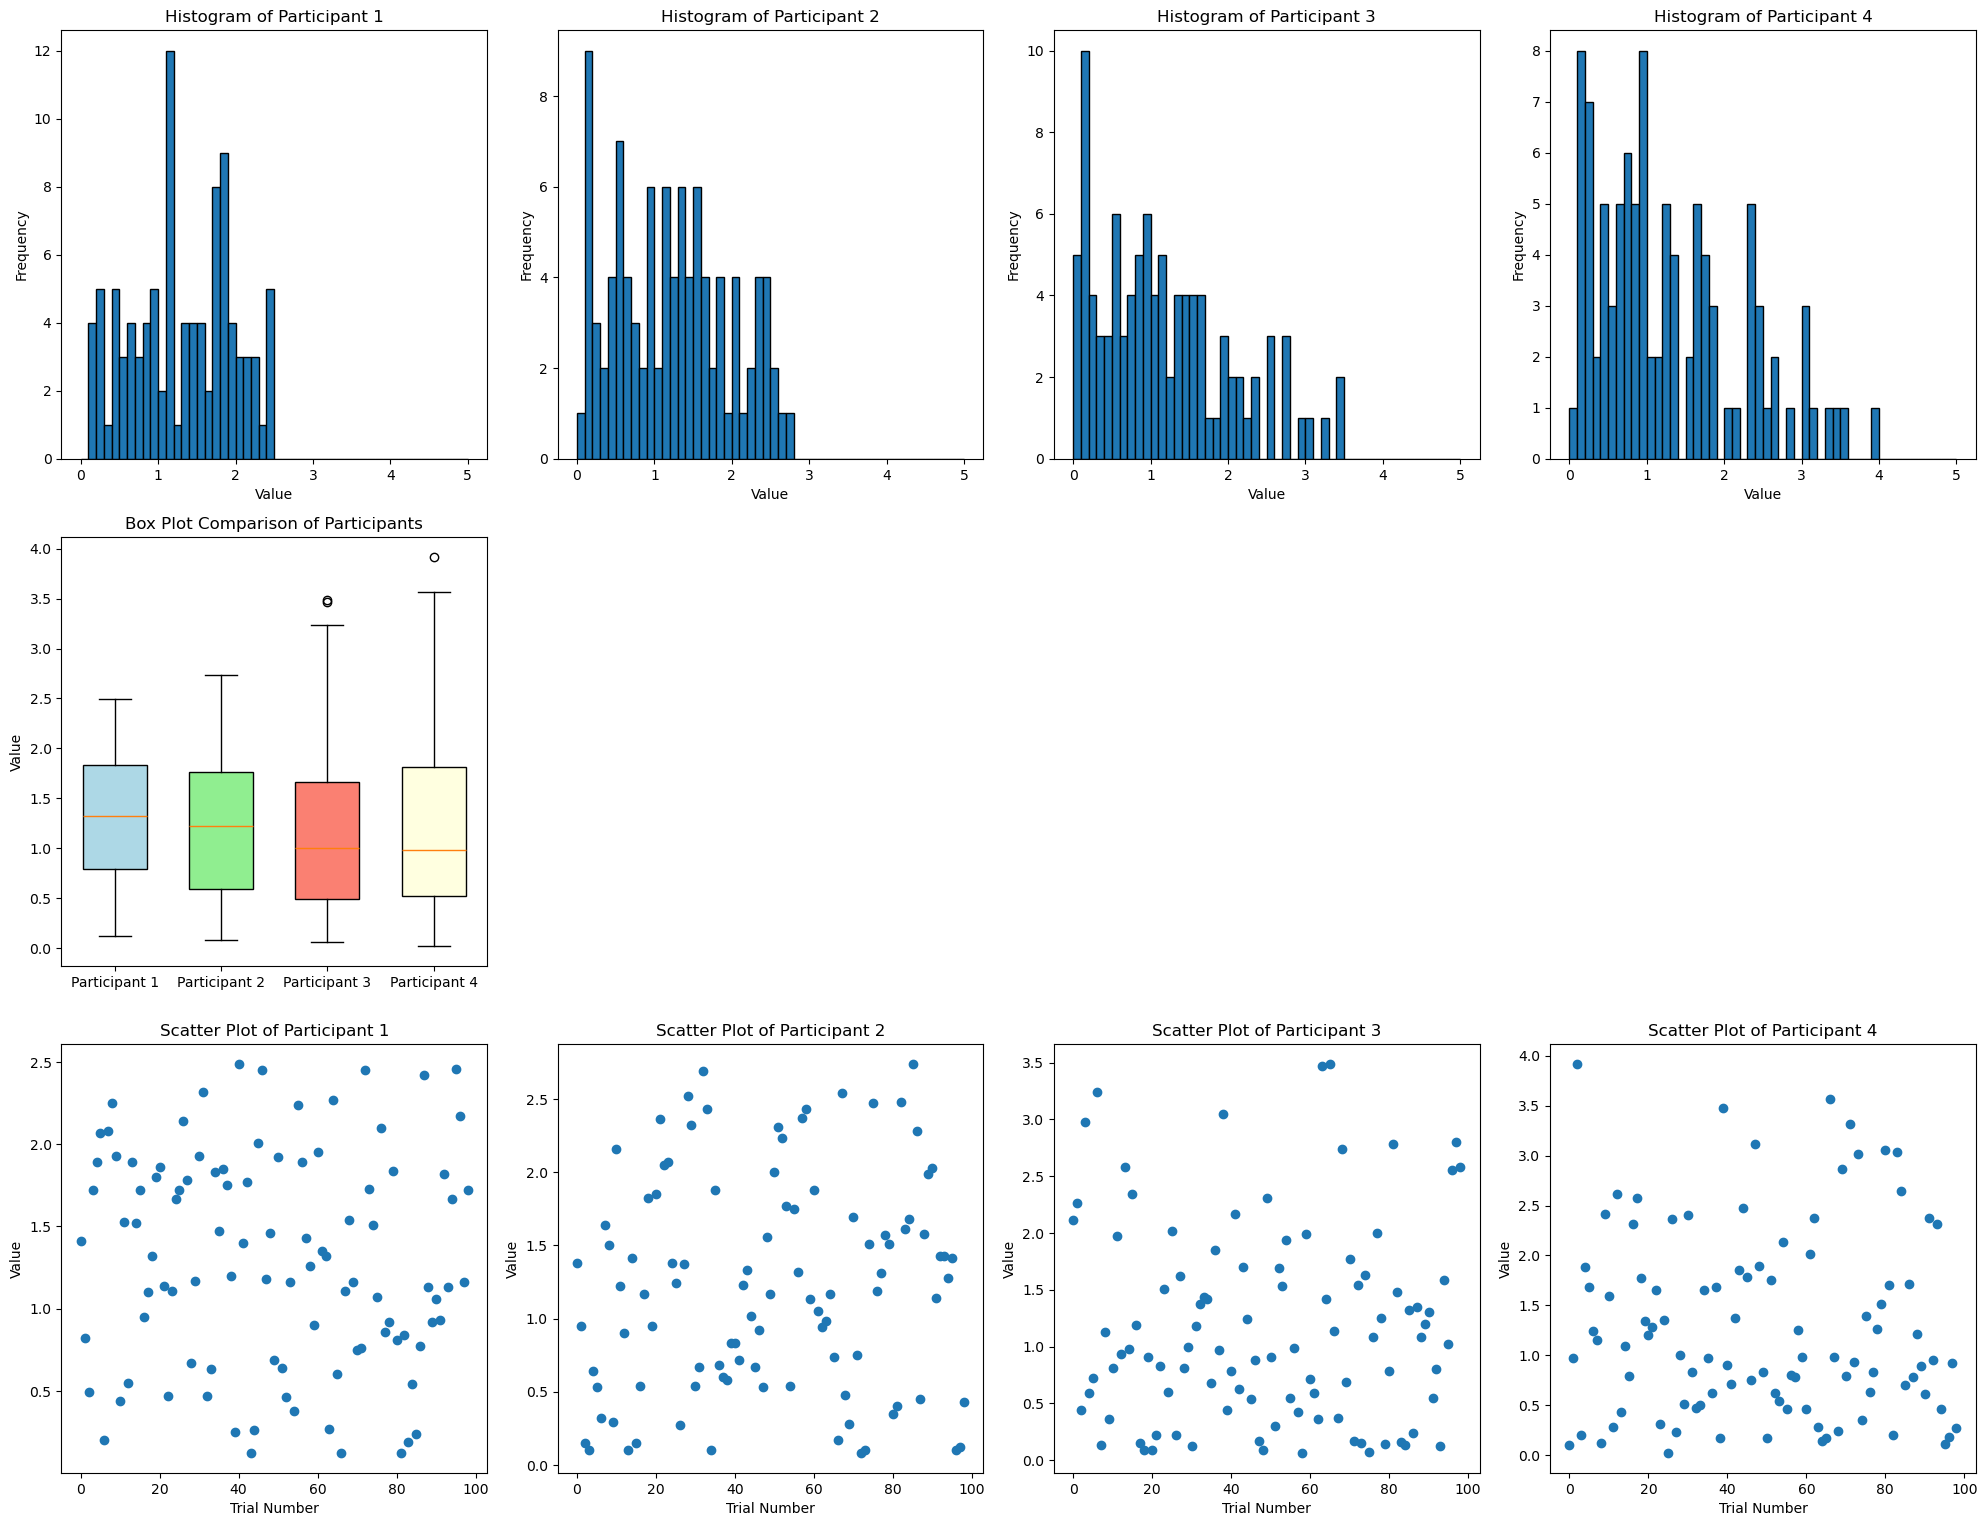

In [5]:
# Read the CSV file  
df = pd.read_csv('data/csv/data2.csv')  # Updated file name  
# View original column names  
print("Original column names:", df.columns.tolist())  
def vis_four_people(df):
    # Rename columns for easier access  
    df.columns = ['Participant1', 'Participant2', 'Participant3', 'Participant4']  
    # Create figures  
    plt.figure(figsize=(20, 20))  

    # Histograms with 0.1 bin width  
    plt.subplot(4, 4, 1)  
    plt.hist(df['Participant1'], bins=np.arange(0, 5.1, 0.1), edgecolor='black')  
    plt.title('Histogram of Participant 1')  
    plt.xlabel('Value')  
    plt.ylabel('Frequency')  

    plt.subplot(4, 4, 2)  
    plt.hist(df['Participant2'], bins=np.arange(0, 5.1, 0.1), edgecolor='black')  
    plt.title('Histogram of Participant 2')  
    plt.xlabel('Value')  
    plt.ylabel('Frequency')  

    plt.subplot(4, 4, 3)  
    plt.hist(df['Participant3'], bins=np.arange(0, 5.1, 0.1), edgecolor='black')  
    plt.title('Histogram of Participant 3')  
    plt.xlabel('Value')  
    plt.ylabel('Frequency')  

    plt.subplot(4, 4, 4)  
    plt.hist(df['Participant4'], bins=np.arange(0, 5.1, 0.1), edgecolor='black')  
    plt.title('Histogram of Participant 4')  
    plt.xlabel('Value')  
    plt.ylabel('Frequency')  

    # Box plots on the same plot with different colors  
    plt.subplot(4, 4, 5)  
    box_data = [df['Participant1'], df['Participant2'], df['Participant3'], df['Participant4']]  
    box_colors = ['lightblue', 'lightgreen', 'salmon', 'lightyellow']  
    box_positions = [1, 2, 3, 4]  

    # Create box plots with patch_artist to allow color fill  
    box_parts = plt.boxplot(box_data, positions=box_positions, patch_artist=True, widths=0.6)  

    # Set colors for each box  
    for i, patch in enumerate(box_parts['boxes']):  
        patch.set_facecolor(box_colors[i])  # Set the face color  
        patch.set_edgecolor('black')  # Set the edge color  

    plt.title('Box Plot Comparison of Participants')  
    plt.ylabel('Value')  
    plt.xticks(box_positions, ['Participant 1', 'Participant 2', 'Participant 3', 'Participant 4'])  

    # Scatter plots  
    plt.subplot(4, 4, 9)  
    plt.scatter(range(len(df['Participant1'])), df['Participant1'])  
    plt.title('Scatter Plot of Participant 1')  
    plt.xlabel('Trial Number')  
    plt.ylabel('Value')  

    plt.subplot(4, 4, 10)  
    plt.scatter(range(len(df['Participant2'])), df['Participant2'])  
    plt.title('Scatter Plot of Participant 2')  
    plt.xlabel('Trial Number')  
    plt.ylabel('Value')  

    plt.subplot(4, 4, 11)  
    plt.scatter(range(len(df['Participant3'])), df['Participant3'])  
    plt.title('Scatter Plot of Participant 3')  
    plt.xlabel('Trial Number')  
    plt.ylabel('Value')  

    plt.subplot(4, 4, 12)  
    plt.scatter(range(len(df['Participant4'])), df['Participant4'])  
    plt.title('Scatter Plot of Participant 4')  
    plt.xlabel('Trial Number')  
    plt.ylabel('Value')  

    # Adjust subplot spacing  
    plt.tight_layout()  

    # Show the plots  
    plt.show()
vis_four_people(df)

## 3. Distribution Modeling
Based on the visualizations of the five participants, the amount for the first participant appears to follow a uniform distribution within a specific range. In contrast, the amount distributions of the other participants do not closely resemble any of the distributions we have studied. Therefore, we will first make a rough comparison of several common distributions.

We tested multiple probability distributions: Uniform distribution; Normal distribution; Gamma distribution and Log-normal distribution.

For each participant's data: We Ploted a histogram to visualize raw data distribution, fitted multiple probability distributions, calculates log-likelihood for each distribution, visualizes fitted probability density functions and ranked distributions based on their statistical fit.

x1: Uniform distribution
x2:
\begin{equation}  
f_{\chi_{2}}(x_2) =  
\begin{cases}  
\frac{n(n-1)}{4m} \ln\left(\frac{n}{n-2}\right), & 0 \leq x \leq \frac{2m(n-2)}{n(n-1)} \\
\frac{n(n-1)}{4m} \ln\left(\frac{2m}{(n-1)x_2}\right), & \frac{2m(n-2)}{n(n-1)} < x_2 \leq \frac{2m}{n-1}  
\end{cases}  
\end{equation}  

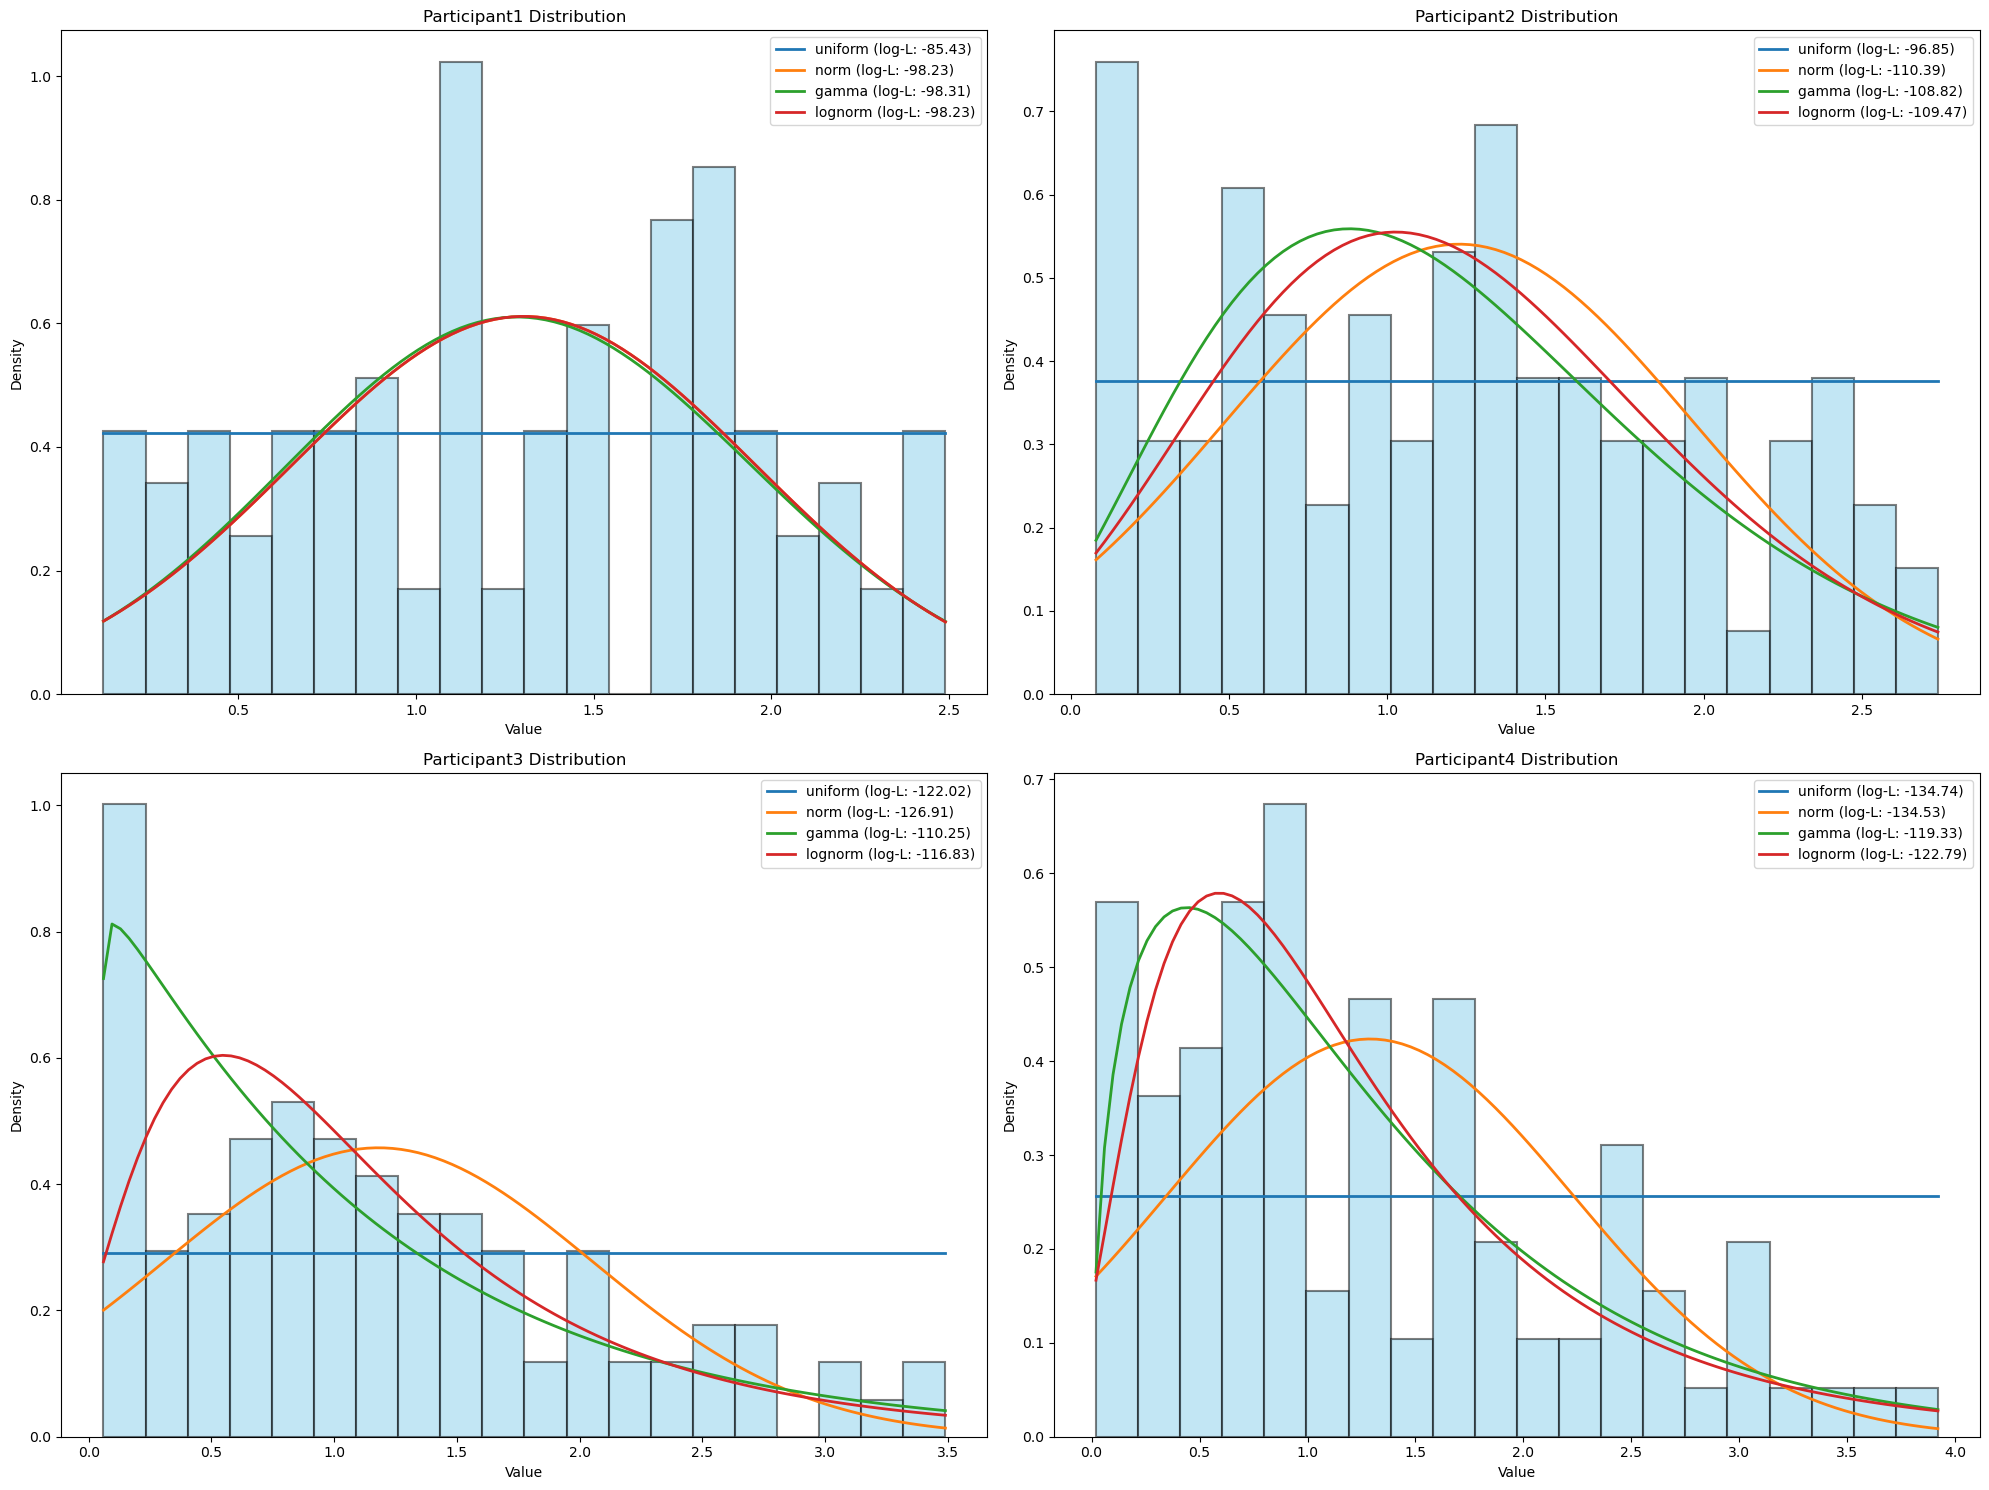


Participant1 distribution fitting results:
Distribution: uniform
Parameters: (0.12, 2.37)
Log-likelihood: -85.42610555955694

Distribution: norm
Parameters: (1.303030303030303, 0.6526642438829804)
Log-likelihood: -98.23236157426494

Distribution: lognorm
Parameters: (1.991702713122946e-05, -32767.87999999997, 32769.18302380342)
Log-likelihood: -98.23243187675307

Distribution: gamma
Parameters: (1207.9777089585227, -21.42600570992815, 0.018815215098743607)
Log-likelihood: -98.30651112133785


Participant2 distribution fitting results:
Distribution: uniform
Parameters: (0.08, 2.66)
Log-likelihood: -96.85428615656713

Distribution: gamma
Parameters: (5.046337941379537, -0.5252401149765062, 0.34750975145734364)
Log-likelihood: -108.81850258200569

Distribution: lognorm
Parameters: (0.18554248695196, -2.780698382870434, 3.9402396154488426)
Log-likelihood: -109.46516009031959

Distribution: norm
Parameters: (1.2274747474747476, 0.7379651841372149)
Log-likelihood: -110.39291027269104


Part

In [30]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from scipy import stats  

# Read data  
df = pd.read_csv('data/csv/data2.csv')  
df.columns = ['Participant1', 'Participant2', 'Participant3', 'Participant4']  

# Define the distributions to test  
distributions = [  
    stats.uniform,   # Uniform distribution  
    stats.norm,      # Normal distribution  
    stats.gamma,     # Gamma distribution  
    stats.lognorm,   # Log-normal distribution  
]  

# Create figure  
plt.figure(figsize=(20, 15))  

# Store the distribution fitting results for each participant  
all_results = {}  

# Analyze for each participant  
for i, participant in enumerate(['Participant1', 'Participant2', 'Participant3', 'Participant4'], 1):  
    data = df[participant]  
    
    # Create a subplot  
    plt.subplot(2, 2, i)  
    
    # Plot the histogram without overlap  
    plt.hist(data, bins=20, density=True, alpha=0.5, color='skyblue', edgecolor='black', linewidth=1.5)  # Set alpha to 0.5 for transparency  
    plt.title(f'{participant} Distribution')  
    plt.xlabel('Value')  
    plt.ylabel('Density')  
    
    # Store current participant's distribution fitting results  
    participant_results = []  
    
    # Fit each distribution  
    for dist in distributions:  
        try:  
            # Maximum likelihood estimation parameters  
            if dist == stats.uniform:  
                # For uniform distribution, use the min and max of the data  
                params = (data.min(), data.max() - data.min())  
                # Calculate the log likelihood for the uniform distribution  
                log_likelihood = np.sum(dist.logpdf(data, params[0], params[1]))  
            else:  
                # Use scipy's fit method for other distributions  
                params = dist.fit(data)  
                # Calculate the log likelihood  
                log_likelihood = np.sum(dist.logpdf(data, *params[:-2], loc=params[-2], scale=params[-1]))  
            
            # Store results  
            participant_results.append({  
                'distribution': dist.name,  
                'params': params,  
                'log_likelihood': log_likelihood  
            })  
            
            # Plot the fitted probability density function  
            x = np.linspace(data.min(), data.max(), 100)  
            if dist == stats.uniform:  
                pdf = dist.pdf(x, params[0], params[1])  
            else:  
                pdf = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])  
            plt.plot(x, pdf, label=f'{dist.name} (log-L: {log_likelihood:.2f})', linewidth=2)  
        
        except Exception as e:  
            print(f"Error fitting {dist.name} for {participant}: {e}")  

    # Sort by log likelihood  
    participant_results.sort(key=lambda x: x['log_likelihood'], reverse=True)  
    
    # Store results  
    all_results[participant] = participant_results  
    
    plt.legend()  

plt.tight_layout()  
plt.show()  

# Print detailed results  
for participant, results in all_results.items():  
    print(f"\n{participant} distribution fitting results:")  
    for result in results:  
        print(f"Distribution: {result['distribution']}")  
        print(f"Parameters: {result['params']}")  
        print(f"Log-likelihood: {result['log_likelihood']}\n")

From the result figures above, it shows that the simulations are far from satisfaction. Therefore, we have use untraditional model to do the modeling. The key observation is that: Assume that there are $N$ people and the total money is $M$, then $X_1 \leq 2\frac{M}{N}$, and the number seems to subdue the uniform distribution:
$$
X_1 \sim Unif(0, 2\frac{M}{N})
$$
Another logic is that the distribution of $X_i, i \neq 1$ must have relation with $X_1$. Assuming that the distribution of the money besides the first person, i.e. $X_i, i \neq 1$, have nothing to do with $X_1$, then the $\sum_{i=1}^N X_i$ can have probability of not equaling $M$, and this scenario is unacceptable. There must be a mechanism to relate $X_i$ with previous data. The intuitive one is to, for example, consider:
$$X_i \sim Unif(0, M-\sum_{j=1}^{i-1}X_j), X_{N-1} = M - \sum_{j=1}^{N-1}X_j$$
But the fatal error is that in this way, the individual money expectation will be obviously distinct. This is against the basic moral, i.e., the assumption that the expectation of each person's money should be the same. Therefore, according to the inspiration from the blog[1][2] and related work[3], the distribution for $X_i, i\in [1, N-1]$ may use the same double expectation trick of $X_1$ to ensure that the overall expectation for each individual is identical. The proof of this conclusion is presented in Appendix.C. Thus the corresponding probable suitable model, so called Double Expectation Model, may suffice the key assumptions and analysis above:

Denote $X_j$ as the money of $j-th$ person, and assume that there are $M$ yuan in total and $N$ people:
$$
X_1 \sim Unif(0, 2\frac{M}{N})
$$
$$
X_j | X_1, \dots, X_{j-1} \sim Unif(0, 2\frac{M-\sum_{i=1}^{j-1}X_i}{N+1-j}), j \in [2, N-1]
$$
$$
X_N | X_1, \dots, X_{N-1} = n-\sum_{i=1}^{N-1} X_i
$$

We attempt to calculate their approximate distribution functions:  


x1: 

$$
X_1 \sim \text{Unif}\left(0, \frac{2n}{m}\right) 
$$
x2:
$$
f_{\chi_{2}}(x_2) =  
\begin{cases}  
\frac{n(n-2)}{4m} \ln\left(\frac{n}{n-2}\right), & 0 \leq x \leq \frac{2m(n-2)}{n(n-1)} \\
\frac{n(n-1)}{4m} \ln\left(\frac{2m}{(n-1)x_2}\right), & \frac{2m(n-2)}{n(n-1)} < x_2 \leq \frac{2m}{n-1}  
\end{cases}  
$$

 But For the distribution after $X_2$, the calculations become too complex. So we give up trying to write the probability mass function for $X_j$ and  using it to fit the distribution.

We use the following codes to generate data of the scenario of four people, and we plot the corresponding histograms. The results are credible, suggesting that this model may well fit the hidden distribution. Note that partial usage of the python library is under the assistance of Generative AI. 

100%|██████████| 10000/10000 [00:00<00:00, 1111162.21it/s]


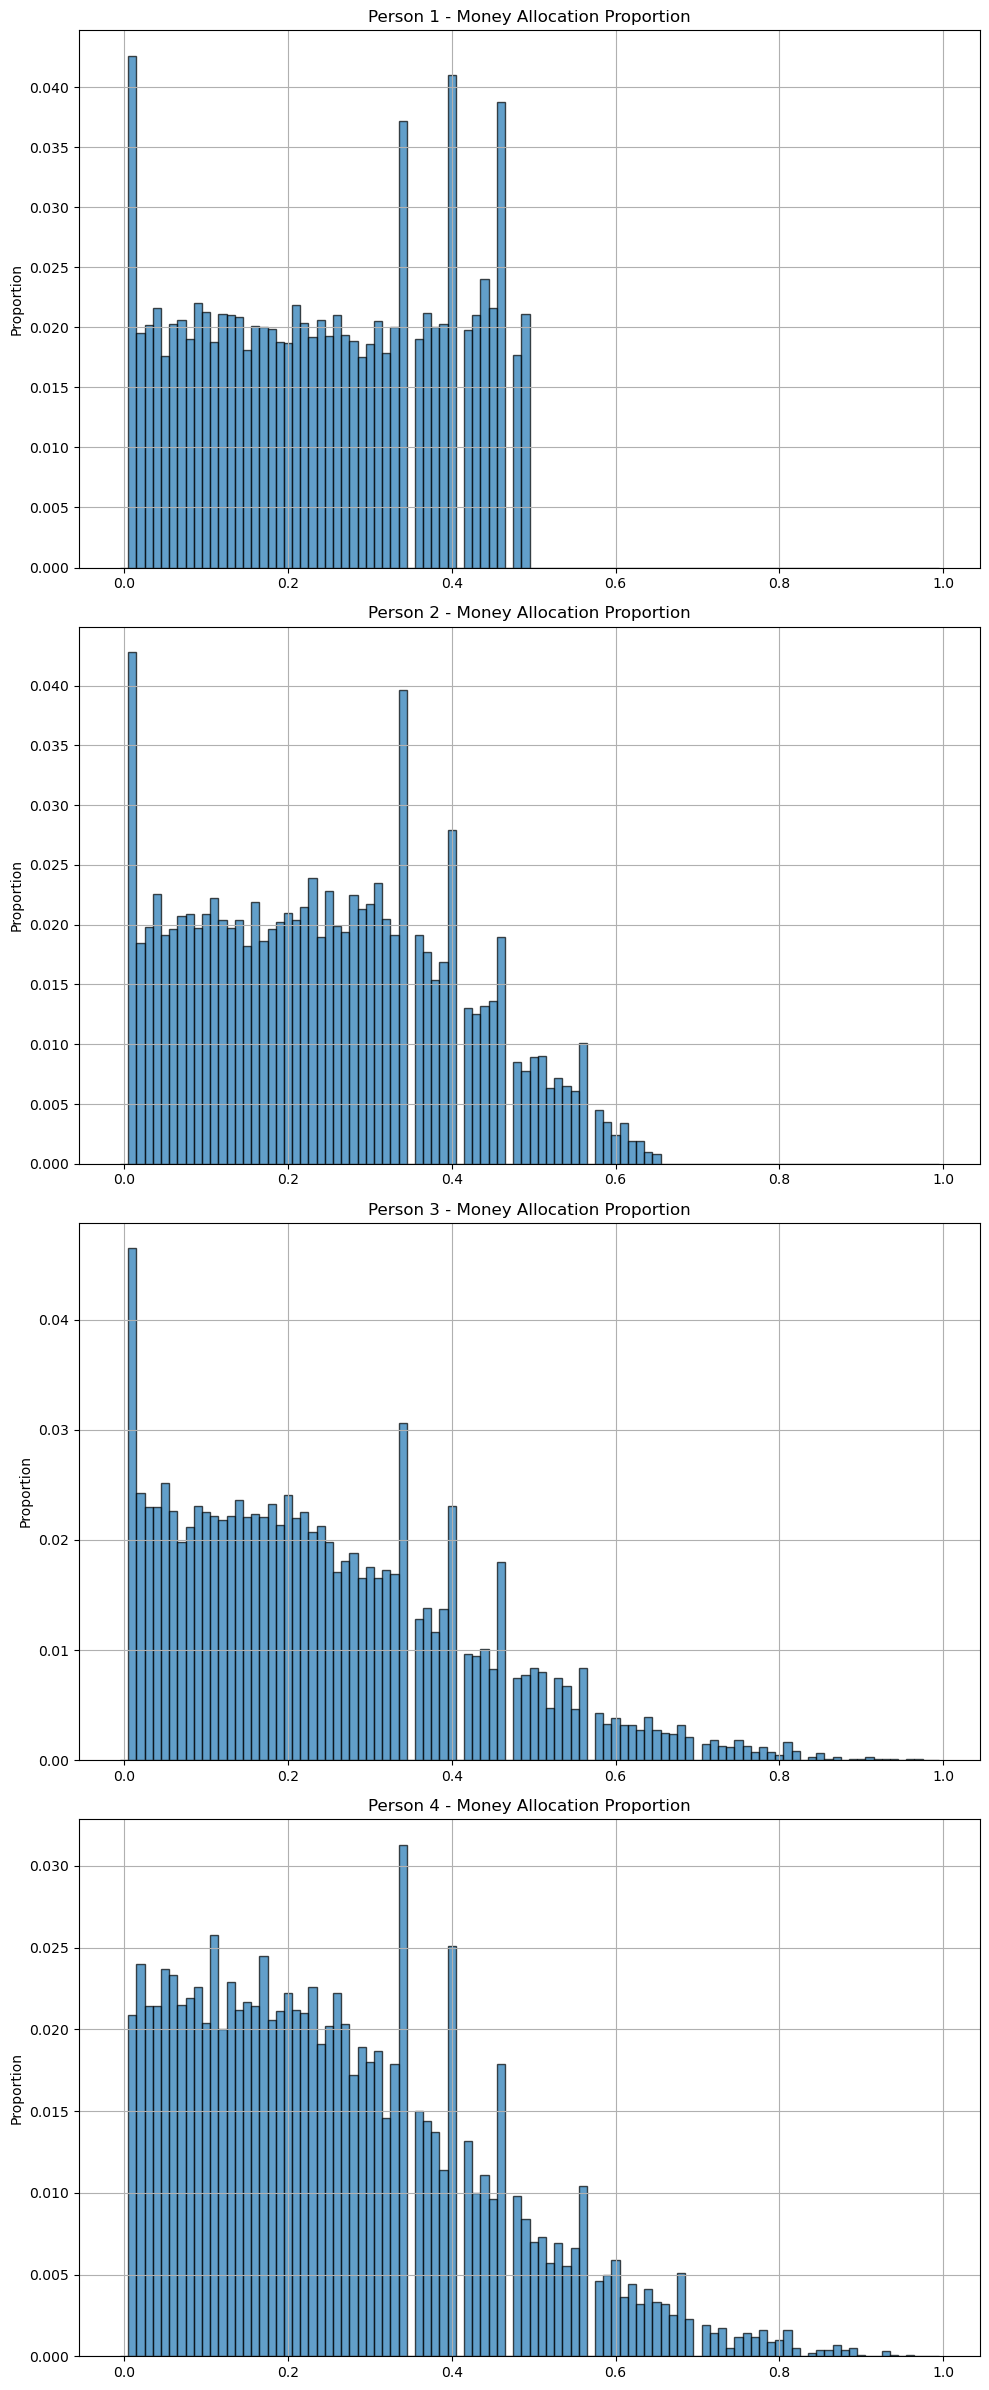

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
# Define the RedPackage class and the money allocation function
class RedPackage:
    def __init__(self, remain_size, remain_money):
        self.remain_size = remain_size
        self.remain_money = remain_money

def get_random_money(red_package):
    if red_package.remain_size == 1:
        red_package.remain_size -= 1
        return round(red_package.remain_money, 2)
    
    min_money = 0.01
    max_money = red_package.remain_money / red_package.remain_size * 2
    money = random.uniform(0, max_money)
    money = max(min_money, money)
    money = int(money * 100) / 100

    red_package.remain_size -= 1
    red_package.remain_money -= money
    return money

# Simulation parameters
num_people = 4
initial_money = 1
num_simulations = 10000
delta = 100

# Data storage
people_money_distributions = {i: [] for i in range(num_people)}

# Simulate the process
for _ in range(num_simulations):
    red_package = RedPackage(remain_size=num_people, remain_money=initial_money)
    for person in range(num_people):
        allocated_money = get_random_money(red_package)
        people_money_distributions[person].append(allocated_money)

generated_data = np.zeros((num_simulations, num_people))
for i in tqdm.tqdm(range(num_simulations)):
    for j in range(num_people):
        generated_data[i][j] = people_money_distributions[j][i]
df = pd.DataFrame(generated_data)
df.to_csv('data/csv/data3.csv', index=False)
# Define the interval (0.05) and the bin edges
interval = 0.01
bin_edges = np.arange(0, initial_money + interval, interval)

# Calculate the proportions of samples within each interval for each person
proportions = {}
for person, money_list in people_money_distributions.items():
    hist, _ = np.histogram(money_list, bins=bin_edges)
    proportions[person] = hist / num_simulations  # Normalize to get the proportion

# Plot the proportions
fig, axes = plt.subplots(num_people, 1, figsize=(10, 6 * num_people))
plt.subplots_adjust(hspace=1)
if num_people == 1:
    axes = [axes]  # Make sure axes is iterable if there's only one plot

for person, ax in enumerate(axes):
    ax.bar(bin_edges[:-1], proportions[person], width=interval, edgecolor='black', alpha=0.7)
    ax.set_title(f"Person {person + 1} - Money Allocation Proportion")
    ax.set_ylabel("Proportion")
    ax.grid(True)

plt.tight_layout()
plt.show()

## 4. Model Testing
To further test our modeling can perform well, we run the code to generate 100 data with 5 yuan in total, 4 people, and then store it. We will further run Chi-Squeare test and Kolmogorov-Smirnov test on the generated and collected data. First, we run the Chi-Squeare test and the code is presented below. Note that partial code is generated by Generative AI.


Column 0 Chi-Square Analysis:
Chi-Square Statistic: 39.0487
P-value: 0.0000
Interpretation:
Reject Null Hypothesis: Significant difference between observed and simulated data

Column 1 Chi-Square Analysis:
Chi-Square Statistic: 12.7563
P-value: 0.1739
Interpretation:
Fail to Reject Null Hypothesis: No significant difference between observed and simulated data

Column 2 Chi-Square Analysis:
Chi-Square Statistic: 10.2110
P-value: 0.3337
Interpretation:
Fail to Reject Null Hypothesis: No significant difference between observed and simulated data

Column 3 Chi-Square Analysis:
Chi-Square Statistic: 13.8983
P-value: 0.1260
Interpretation:
Fail to Reject Null Hypothesis: No significant difference between observed and simulated data


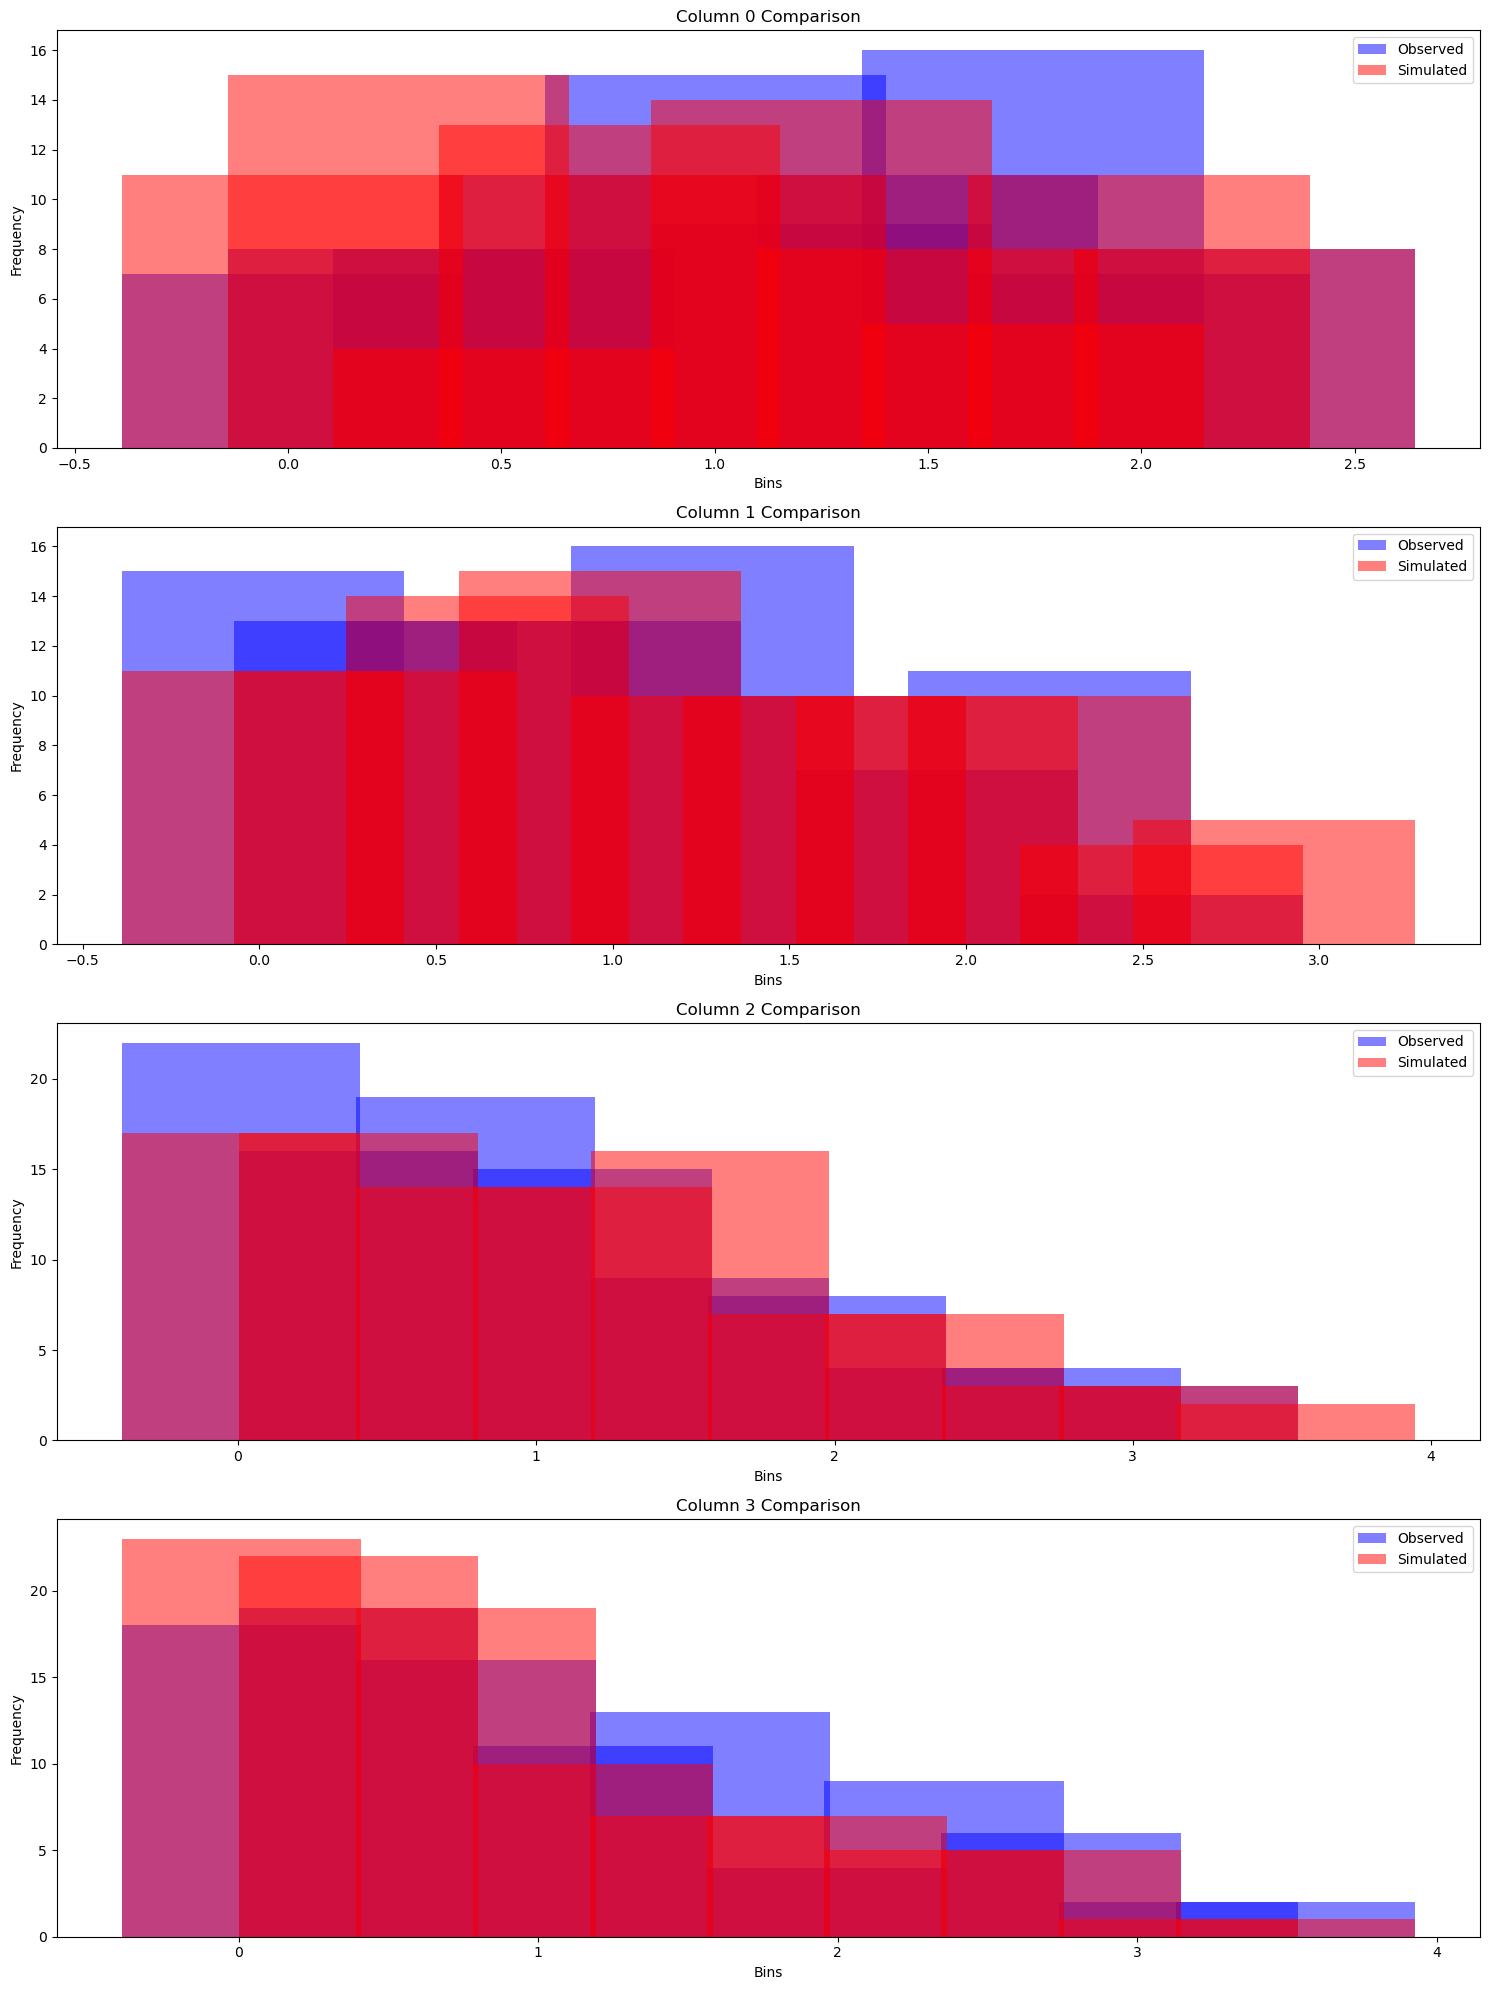

In [9]:
from scipy import stats
df_observed = pd.read_csv('data/csv/data2.csv', header=None)
df_simulated = pd.read_csv('data/csv/data3.csv', header=None)

# Function to perform chi-square test for each column
def chi_square_analysis(observed_col, simulated_col):
    # Create histogram bins
    # Use the same number of bins for both datasets to ensure comparability
    min_val = min(observed_col.min(), simulated_col.min())
    max_val = max(observed_col.max(), simulated_col.max())
    
    # Create 10 bins across the data range
    bins = np.linspace(min_val, max_val, 11)
    
    # Compute frequency in each bin
    obs_hist, _ = np.histogram(observed_col, bins=bins)
    sim_hist, _ = np.histogram(simulated_col, bins=bins)
    
    # Perform chi-square test
    # Use chi-square test of independence
    chi2_stat, p_value = stats.chisquare(obs_hist, sim_hist)
    return {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'obs_hist': obs_hist,
        'sim_hist': sim_hist,
        'bins': bins[:-1]  # exclude the last bin edge
    }

# Store results for each column
results = []

# Perform analysis for each column
for col in range(df_observed.shape[1]):
    column_result = chi_square_analysis(
        df_observed[col], 
        df_simulated[col]
    )
    column_result['column'] = col
    results.append(column_result)

# Visualization and detailed reporting
plt.figure(figsize=(15, 5 * len(results)))
for i, result in enumerate(results):
    plt.subplot(len(results), 1, i+1)
    plt.bar(result['bins'], result['obs_hist'], alpha=0.5, label='Observed', color='blue')
    plt.bar(result['bins'], result['sim_hist'], alpha=0.5, label='Simulated', color='red')
    plt.title(f'Column {result["column"]} Comparison')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Print statistical results
    print(f"\nColumn {result['column']} Chi-Square Analysis:")
    print(f"Chi-Square Statistic: {result['chi2_statistic']:.4f}")
    print(f"P-value: {result['p_value']:.4f}")
    print("Interpretation:")
    if result['p_value'] < 0.05:
        print("Reject Null Hypothesis: Significant difference between observed and simulated data")
    else:
        print("Fail to Reject Null Hypothesis: No significant difference between observed and simulated data")

plt.tight_layout()
plt.show()

Then we will run the Kolmogorov-Smirnov test and the code is presented below. Note that partial code is generated by Generative AI.

In [10]:
def compare_distributions(file1, file2):
    # Read CSV files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    # Ensure the files have the same number of columns
    if df1.shape[1] != df2.shape[1]:
        raise ValueError("The two CSV files must have the same number of columns")
    
    # Dictionary to store test results
    ks_results = {}
    
    # Perform Kolmogorov-Smirnov test for each column
    for column in range(df1.shape[1]):
        # Extract column data, converting to numeric and dropping NaNs
        data1 = pd.to_numeric(df1.iloc[:, column], errors='coerce').dropna()
        data2 = pd.to_numeric(df2.iloc[:, column], errors='coerce').dropna()
        
        # Perform Kolmogorov-Smirnov test
        statistic, p_value = stats.ks_2samp(data1, data2)
        
        # Store results
        ks_results[column] = {
            'statistic': round(statistic, 4),
            'p_value': round(p_value, 4),
            'significant_diff': p_value < 0.05  # Standard significance level
        }
    
    return ks_results

# Perform the comparison
results = compare_distributions('data/csv/data2.csv', 'data/csv/data3.csv')

# Print detailed results
print("Kolmogorov-Smirnov Test Results:")
for column, result in results.items():
    print(f"\n- **Column {column}**:")
    print(f"  - KS Statistic: {result['statistic']}")
    print(f"  - P-value: {result['p_value']}")
    print(f"  - Significant Difference: {'Yes' if result['significant_diff'] else 'No'}")

# Additional interpretation
significant_columns = [col for col, res in results.items() if res['significant_diff']]
print("\nConclusion:")
if not significant_columns:
    print("All columns have p-values greater than 0.05, so we cannot reject the null hypothesis. This indicates no significant distribution differences between actual measurements and ideal simulations across the columns.")
else:
    print(f"Columns {', '.join(map(str, significant_columns))} show significant distribution differences. Other columns do not have significant differences.")

Kolmogorov-Smirnov Test Results:

- **Column 0**:
  - KS Statistic: 0.1313
  - P-value: 0.3621
  - Significant Difference: No

- **Column 1**:
  - KS Statistic: 0.1212
  - P-value: 0.463
  - Significant Difference: No

- **Column 2**:
  - KS Statistic: 0.1212
  - P-value: 0.463
  - Significant Difference: No

- **Column 3**:
  - KS Statistic: 0.1313
  - P-value: 0.3621
  - Significant Difference: No

Conclusion:
All columns have p-values greater than 0.05, so we cannot reject the null hypothesis. This indicates no significant distribution differences between actual measurements and ideal simulations across the columns.


Both the Chi-Square test and Kolmogorov-Smirnov test show promising results, indicating that this modeling is a successful one, except for the fact that in $X_1$ of Chi-Square the p-value is extremely small (close to zero). This is because the number of random distribution at the beginning can differ greatly from one to another. The principle of Chi-Square test is to compare the data frequency of observation and expectation, and this may lack efficiency and accuracy when comparing two purely and randomly distributed data, especially when the number of sample is not sufficient enough. For $X_i,i \neq 1$, their conditional uniform distribution may not suffer from the variation. 

In conclusion: Chi-Square test requires large number of samples, which can been inducted by the aforementioned failure on $X_1$, but it can be applied to the category data and its mechanism is easy to understand. Kolmogorov-Smirnov's demand for ample samples is not as severe as Chi-Square, but it is insensitive to tail accounting[4]. Luckily that $X_i$ of two data don't have significant difference on the tail. 

## 5. Generative Modeling
For this section, we modify the diffusion model so as to learn the latent distribution behind the data and hence generate new data. The code supports running with GPU. The code is partially borrowed from the open tutorial resource published on github, and partial debugging is under the assistance of ChatGPT. We run the code on GPU of NVIDIA GeForce RTX 4070 Laptop, with the CPU of 13th Gen Intel(R) Core(TM) i9-13980HX.

### 5.1 Code Implementaion
The entire code is presented below. Again, it should be noted that the main idea of the neural network comes from diffusion model[5], partial code is borrowed from an open github repository[6], and partial debugging is under the assistance of ChatGPT. The csv file is transformed into numpy array file for conveniece, and the transformation code will be presented in Appendix.B.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess data
data = np.load('data/raw_data_1.npy')
dataset = torch.Tensor(data).float().to(device)
dimension = data.shape[1]
print("The dimension of the data is: ", dimension, " and the number of samples is: ", data.shape[0], 'The shape of the data is: ', data.shape)
# Hyperparameters
num_steps = 100  # Diffusion process time steps
num_epochs = 4000  # Number of training epochs
batch_size = 32 # Batch size

# Create beta schedule (linearly increasing betas)
betas = torch.linspace(1e-5, 0.5e-2, num_steps).to(device)

# Compute alpha and related terms
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, dim=0)
alphas_prod_p = torch.cat([torch.tensor([1.0], device=device), alphas_prod[:-1]], dim=0)
alphas_bar_sqrt = torch.sqrt(alphas_prod).to(device)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod).to(device)

# Noise addition function in diffusion process
def q_x(x_0, t):
    noise = torch.randn_like(x_0).to(device)  # Standard normal noise
    alphas_t = alphas_bar_sqrt[t].unsqueeze(1)  # Shape: (batch_size, 1)
    alphas_l_m_t = one_minus_alphas_bar_sqrt[t].unsqueeze(1)  # Shape: (batch_size, 1)
    return alphas_t * x_0 + alphas_l_m_t * noise

# Checkpoint functions
def save_checkpoint(model, optimizer, epoch, loss, filename):
    """Save model and optimizer state."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")

def load_checkpoint(model, optimizer, filename, device):
    """Load model and optimizer state."""
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {filename} at epoch {epoch} with loss {loss}")
    return epoch, loss

# Define the MLP Diffusion model
class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, dimension, num_units=128):
        super(MLPDiffusion, self).__init__()
        self.step_embedding = nn.Embedding(n_steps, num_units)
        self.net = nn.Sequential(
            nn.Linear(dimension + num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, dimension),  # Output dimensions (x1, x2, x3)
        )

    def forward(self, x, t):
        t_embedding = self.step_embedding(t)  # Shape: (batch_size, num_units)
        x = torch.cat([x, t_embedding], dim=1)  # Concatenate along feature dimension
        return self.net(x)

# Loss function: Mean Squared Error between predicted and true noise
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]

    # Randomly sample a timestep t for each example in the batch
    t = torch.randint(0, n_steps, size=(batch_size,), device=device)

    # Compute noisy input x(t)
    a = alphas_bar_sqrt[t].unsqueeze(1)  # Shape: (batch_size, 1)
    e = torch.randn_like(x_0).to(device)  # Shape: (batch_size, 3)
    aml = one_minus_alphas_bar_sqrt[t].unsqueeze(1)  # Shape: (batch_size, 1)
    x = a * x_0 + aml * e  # Shape: (batch_size, 3)

    # Predict the noise using the model
    output = model(x, t)  # Shape: (batch_size, 3)

    # Compute the loss (MSE between true noise and predicted noise)
    return ((e - output) ** 2).mean()

# Training function
def train_model(model, dataset, optimizer, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_epochs):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x in dataloader:
            batch_x = batch_x.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Compute loss
            loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_x.size(0)

        epoch_loss /= len(dataloader.dataset)

        if (epoch + 1) % 100 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.6f}")

    return epoch_loss

# Sampling functions
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt, device):
    # Compute coefficients and reshape to (batch_size, 1) for broadcasting
    coeff = (betas[t] / one_minus_alphas_bar_sqrt[t]).unsqueeze(1)  # Shape: (1000, 1)
    inv_sqrt_one_minus_betas = (1 / torch.sqrt(1 - betas[t])).unsqueeze(1)  # Shape: (1000, 1)
    sqrt_betas = torch.sqrt(betas[t]).unsqueeze(1)  # Shape: (1000, 1)
    
    # Predict the noise using the model
    eps_theta = model(x, t)  # Shape: (1000, 3)
    
    # Compute the mean
    mean = inv_sqrt_one_minus_betas * (x - coeff * eps_theta)  # Shape: (1000, 3)
    
    # Sample noise for the current step
    z = torch.randn_like(x).to(device)  # Shape: (1000, 3)
    
    # Compute the sample
    sample = mean + sqrt_betas * z  # Shape: (1000, 3)
    
    return sample

def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt, device):
    """
    Generate samples by iteratively applying p_sample.
    """
    model.eval()
    with torch.no_grad():
        cur_x = torch.randn(shape).to(device)  # Initialize with random noise
        x_seq = [cur_x]
        for i in reversed(range(n_steps)):
            t = torch.full((shape[0],), i, dtype=torch.long, device=device)  # Shape: (1000,)
            cur_x = p_sample(model, cur_x, t, betas, one_minus_alphas_bar_sqrt, device)  # Shape: (1000, 3)
            x_seq.append(cur_x)
    return x_seq

# Initialize model, optimizer, and train
model = MLPDiffusion(num_steps, dimension, num_units=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
checkpoint_filename = 'data/checkpoint0.ckpt'

# Train the model
final_loss = train_model(model, dataset, optimizer, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_epochs)

# Save the checkpoint
save_checkpoint(model, optimizer, num_epochs, final_loss, checkpoint_filename)

# Load the checkpoint (if needed)
# load_checkpoint(model, optimizer, checkpoint_filename, device)

# Generate samples
generated_samples_seq = p_sample_loop(model, (1000, dimension), num_steps, betas, one_minus_alphas_bar_sqrt, device)

# Extract the final generated samples
generated_samples = generated_samples_seq[-1].cpu().detach().numpy()
np.save('data/simulated_data_from_raw_1.npy', generated_samples)

The dimension of the data is:  3  and the number of samples is:  100 The shape of the data is:  (100, 3)
Epoch 100/4000, Loss: 1.088040
Epoch 200/4000, Loss: 0.961575
Epoch 300/4000, Loss: 0.941220
Epoch 400/4000, Loss: 0.892722
Epoch 500/4000, Loss: 0.883179
Epoch 600/4000, Loss: 0.679047
Epoch 700/4000, Loss: 0.729403
Epoch 800/4000, Loss: 0.818805
Epoch 900/4000, Loss: 0.765993
Epoch 1000/4000, Loss: 0.667908
Epoch 1100/4000, Loss: 0.670130
Epoch 1200/4000, Loss: 0.737057
Epoch 1300/4000, Loss: 0.715201
Epoch 1400/4000, Loss: 0.617570
Epoch 1500/4000, Loss: 0.634679
Epoch 1600/4000, Loss: 0.808228
Epoch 1700/4000, Loss: 0.633606
Epoch 1800/4000, Loss: 0.640750
Epoch 1900/4000, Loss: 0.752138
Epoch 2000/4000, Loss: 0.673670
Epoch 2100/4000, Loss: 0.691086
Epoch 2200/4000, Loss: 0.580521
Epoch 2300/4000, Loss: 0.565571
Epoch 2400/4000, Loss: 0.655265
Epoch 2500/4000, Loss: 0.631473
Epoch 2600/4000, Loss: 0.706466
Epoch 2700/4000, Loss: 0.799557
Epoch 2800/4000, Loss: 0.649726
Epoch 29

### 5.2 Methodology
In the paper of diffusion model[5], the pseudocode of the paradigm on training and sampling is presented as belows:
<div style="display: flex; align-items: center;">
    <img src="image/pesudo1.png"  style="margin-right: 10px;">
    <img src="image/pseudo2.png" >
</div>

In the pseudocode above, $\alpha_t = 1-\beta_t$, $\overline{\alpha_t} = \prod_{s-1}^t \alpha_s$, where $\beta$ denotes the beta schedule which increases linearly. $\epsilon$ denotes noise and $x_0$ denotes the original data, meanwhile $x_T$ denotes that generated noise under normal distribution. Here we will apply the algorithm above to our specific task. \
The data stream and network component is presented in the figure below:

![image](image/training_network.png)

In the figure of training, $X_0 \in R^{bs \times d}$ is the input data distribution where $bs$ denotes batch size and $d$ denotes the dimension of the input data. Using the generated noise $\epsilon$ and the original batch data under specific proportion, a noised sample is generated. The randomly chosen specific timestep t is embedded into latent space of dimension $ld$, and it will be concatenated with the noised sample. It should be noted that $ld$ is actually a hyperparameter. Then the concatenated tensor will be processed by three blocks which individually consists of a Linear Layer and a ReLU activation funcion. Finally, the processed tensor will be projected to the wanted dimension $d$ and is expected to be a close simulation of the original generated noise $\epsilon$. Here we use the MSE Loss as the loss function for backpropogation. We emphasize that during training, the time step t is randomly chosen, not orderly chosen, so as to fully maximize every batch of data since in this way every batch data can be cooperated with a different timestep t which, to some extent, improve the robustness of the network. The noise predictor in this implementation consists of four linear layers, three activation functions, and involves an embedding layer for projecting discrete timestep into continuous latent space.

![image](image/sampling.png)

In the figure of sampling, we firstly generate a noise tensor with dimension $num \times d$, which subdues normal dirtribution. Then starting from the timestep t to 1, we will input the noised distribution and the timestep into the noise predictor to generated a simulated noise. Then we will use the noised data and simulated noise to generated the data one step ahead, in the proportion illustrated in the pseudocode of sampling. The generated $X_{t-1}$ will be the input of the next block, together with timestep $t-1$ correspondingly. This process will be repeated $t$ times until $X_0$ is generated, which should be expected to yield the same distribution of the input data.  

### 5.3 Experiment
Unless additionally stated, we set up 4000 epochs and 100 timesteps. The dimension of the hidden space for timestep $t$ is 128, and the batch size is set to 32 with dataloader's shuffling mode on. It is noticeable that the timestep isn't rather large, since it is generally considered that the data distribution is not way too complicated and excessive training and inferencing isn't necessary. 
### Result and Visualization on 3D Experiment
We train our model on the dataset of $R^{100, 3}$, i.e., on the dataset consisting of 100 data on 3 people's money while the total amount of money is 5, specifically speaking. Since the data visualization for three dimensional dataset is quite accessable, here we visualize the data distribution of the original dataset and generated dataset that comprises 1000 pieces of data, respectively. The visualization code is presented in Appendix.B. Note that the figures of visualization are from the result we run on our computer, not this Jupyter Notebook. You can use the visualization code in Appendix.A and the 'simulated_data_from_raw_1.npy' file this jupyter created to visualize it yourself. 
<div style="display: flex; align-items: center;">
    <img src="image/vis_collected.png"  style="margin-right: 10px;">
    <img src="image/dif_col_generated_1.png" style="margin-right: 10px;" >
    <img src="image/dif_col_generated_2.png"  style="margin-right: 10px;">
</div>

From the figure above, starting from left to right, the pictures are about the visualization for the original data, the visualization the generated data, and another view into the visualization of the generated data. It is manifest that the simulated data subdues the distribution of the orignal data well, which is indicated by the tiny jittering of the plane in the figure. This is intuitive that the simulation is quite good since the hidden distribution of the original data is not obscure, and the network can easily learn the linear paterns behind the data. Not to further mention that the data is only three dimensional. 

### Result and Visualization on 4D experiment
We also train our model on a (100, 4) dataset. Since it is hard to do visualization for 4 dimensional data, we convert the npy file to csv and further do Kolmogorov-Smirnov Test. The code and test results are presented below, indicating that the newly generated data share the same latent distribution with the old collected data.

In [16]:
data = np.load('data/simulated_data_from_raw_2.npy')  # 替换 'your_file.npy' 为你的文件名
print("There are totally", data.shape[0], "pieces of samples, and there are", data.shape[1], "people in total.")
# 将 NumPy 数组转换为 Pandas DataFrame
df = pd.DataFrame(data)

# 将 DataFrame 写入 CSV 文件
df.to_csv('data/csv/diffusion_generated_four.csv', index=False)  # 替换 'output_file.csv' 为你想要输出的文件名

# Perform the comparison
results = compare_distributions('data/csv/data2.csv', 'data/csv/diffusion_generated_four.csv')

# Print detailed results
print("Kolmogorov-Smirnov Test Results:")
for column, result in results.items():
    print(f"\n- **Column {column}**:")
    print(f"  - KS Statistic: {result['statistic']}")
    print(f"  - P-value: {result['p_value']}")
    print(f"  - Significant Difference: {'Yes' if result['significant_diff'] else 'No'}")

# Additional interpretation
significant_columns = [col for col, res in results.items() if res['significant_diff']]
print("\nConclusion:")
if not significant_columns:
    print("All columns have p-values greater than 0.05, so we cannot reject the null hypothesis. This indicates no significant distribution differences between actual measurements and ideal simulations across the columns.")
else:
    print(f"Columns {', '.join(map(str, significant_columns))} show significant distribution differences. Other columns do not have significant differences.")

There are totally 1000 pieces of samples, and there are 4 people in total.
Kolmogorov-Smirnov Test Results:

- **Column 0**:
  - KS Statistic: 0.0636
  - P-value: 0.8349
  - Significant Difference: No

- **Column 1**:
  - KS Statistic: 0.0694
  - P-value: 0.7501
  - Significant Difference: No

- **Column 2**:
  - KS Statistic: 0.1262
  - P-value: 0.1036
  - Significant Difference: No

- **Column 3**:
  - KS Statistic: 0.1064
  - P-value: 0.2403
  - Significant Difference: No

Conclusion:
All columns have p-values greater than 0.05, so we cannot reject the null hypothesis. This indicates no significant distribution differences between actual measurements and ideal simulations across the columns.


## 6. Further Discussion and Theoretical Analysis
### 6.1 Clicking Strategy
Since the expectation money of each person is identical which is proved in Appendix.C, so actually when the number of clicked red envelope containing the same total money grows to infinity, the expectation will always be the same. But it can be proved that: the later you click the envelope, the higher your money variance is. The proof is presented in Appendix.C. So if you want to take risks to receive more money relatively to others, you can click the red envelope later. Meanwhile, if you want to secure median amount of money and you are satisfied with it, you can click the red envelop as early as possible. In this strategy, the number of people in Wechat Group and the number of people who have already obtained the red envelope doesn't matter. The only decision you have to make is about how soon or how late you will click the red envelope.
### 6.2 Holiday Factor
Will the distribution change when it comes to special days? Intuitively, this shouldn't be true. Still, we collected additional datesets on Jan 1st, 2025, with 5 yuan in total, 25 trials, three or four people respectively. Then we will run only Kolmogorov-Smirnov test on these two datasets since the sample number is too small.

The result on the data containing three people:

In [28]:
# Perform the comparison
results = compare_distributions('data/csv/data1.csv', 'data/csv/data4.csv')

# Print detailed results
print("Kolmogorov-Smirnov Test Results:")
for column, result in results.items():
    print(f"\n- **Column {column}**:")
    print(f"  - KS Statistic: {result['statistic']}")
    print(f"  - P-value: {result['p_value']}")
    print(f"  - Significant Difference: {'Yes' if result['significant_diff'] else 'No'}")

# Additional interpretation
significant_columns = [col for col, res in results.items() if res['significant_diff']]
print("\nConclusion:")
if not significant_columns:
    print("All columns have p-values greater than 0.05, so we cannot reject the null hypothesis. This indicates no significant distribution differences between actual measurements and ideal simulations across the columns.")
else:
    print(f"Columns {', '.join(map(str, significant_columns))} show significant distribution differences. Other columns do not have significant differences.")

Kolmogorov-Smirnov Test Results:

- **Column 0**:
  - KS Statistic: 0.1833
  - P-value: 0.4741
  - Significant Difference: No

- **Column 1**:
  - KS Statistic: 0.2467
  - P-value: 0.1588
  - Significant Difference: No

- **Column 2**:
  - KS Statistic: 0.21
  - P-value: 0.3121
  - Significant Difference: No

Conclusion:
All columns have p-values greater than 0.05, so we cannot reject the null hypothesis. This indicates no significant distribution differences between actual measurements and ideal simulations across the columns.


The result on the data containing four people:

In [29]:
# Perform the comparison
results = compare_distributions('data/csv/data2.csv', 'data/csv/data5.csv')

# Print detailed results
print("Kolmogorov-Smirnov Test Results:")
for column, result in results.items():
    print(f"\n- **Column {column}**:")
    print(f"  - KS Statistic: {result['statistic']}")
    print(f"  - P-value: {result['p_value']}")
    print(f"  - Significant Difference: {'Yes' if result['significant_diff'] else 'No'}")

# Additional interpretation
significant_columns = [col for col, res in results.items() if res['significant_diff']]
print("\nConclusion:")
if not significant_columns:
    print("All columns have p-values greater than 0.05, so we cannot reject the null hypothesis. This indicates no significant distribution differences between actual measurements and ideal simulations across the columns.")
else:
    print(f"Columns {', '.join(map(str, significant_columns))} show significant distribution differences. Other columns do not have significant differences.")

Kolmogorov-Smirnov Test Results:

- **Column 0**:
  - KS Statistic: 0.3081
  - P-value: 0.0398
  - Significant Difference: Yes

- **Column 1**:
  - KS Statistic: 0.2513
  - P-value: 0.1443
  - Significant Difference: No

- **Column 2**:
  - KS Statistic: 0.1098
  - P-value: 0.9503
  - Significant Difference: No

- **Column 3**:
  - KS Statistic: 0.2652
  - P-value: 0.1084
  - Significant Difference: No

Conclusion:
Columns 0 show significant distribution differences. Other columns do not have significant differences.


The result below hints that the distribution are the same, no matter whether it is a special day or not. Note that in the result of four people, p-value equals 0.04, which is slightly smaller than 0.05. This is considered normal since the number of sample is small, and the money distribution of the first people is purely randomly distributed. In conclusion, we tend to disagree that holiday could be a possible factor effecting the data distribution

### 6.3 User-Specific Mechanism
Consider a special Wechat Group, where everyone want to have rather considerable amount of money when receiving red envelopes, or someone is a super vip and should receive more money. This requires the algorithm to have control over the overall distribution robustly. We deesign the following algorithm. Assuming there are N people and M yuan:
$$
Y_1, Y_2, \dots, Y_n \sim N(0, \sigma ^2)
$$
$$
w_1, w_2, \dots, w_n \in \mathbf{R^+}
$$
$$
X_i = N\frac{w_iY_i}{\sum_{i=1}^N Y_i}
$$
where $\sigma, w_i$ are hyperparameters. The $i-th$ person , whose weight is $w_i$, will take away the number according to his weight index, i.e., $X_i$. Note that in this algorithm, the numbers are determined previously. We use $\sigma$ to control the initial variance of data distribution, and we use $w_i$ to designate weight to each individual. For instance, Pony is a VVVIP user of Penguin social app, and Penguin company have rule that VVVIP will have more money when receiving envelope. Therefore we can set $w_{pony}$ relatively rather large. When Pony click the red envelope, he takes away $X_{pony}$ yuan, whose weight is $w_{pony}$. For another example, for a group of children, since we don't want to break their heart, we want to share the money as fair as possible. We can set $\sigma$ rather small, and set there weights $w_i$ identical. 

## Appendix
### A. Visualization Code
````python
import torch
import matplotlib.pyplot as plt
import numpy as np

data = np.load('code/data/toy.npy')
print(data.shape)
data = data[:, :3]
# Data preprocessing
dataset = torch.Tensor(data).float()  # shape: (10000, 3)

# Visualize data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], color='red', s=10, edgecolors='black')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.show()

### B. From csv to npy
````python
import pandas as pd
import numpy as np

# Load the data from a CSV file
df = pd.read_csv('')

# Convert the data to a numpy array
data = df.to_numpy()

# Save the data as a .npy file
np.save('', data)

### C. Proof on Variation Theorem
Note that the proof is mainly borrowed from the video[7]. 

Let the number of red packets be $ n $, and the total amount be $ S $. Let $ X_i $ be the amount of money the $ i $-th person grabs, and $ S_i $ be the total amount of money grabbed after the $ i $-th person. Define $ X_0=0, S_0=0 $.

Given:
$ X_1 \sim \text{Uniform}\left(0,\frac{2S}{n}\right) $
$\left\{ \begin{array}{l} X_{i+1} \mid S_i \sim \text{Uniform}\left(0,\frac{2(S-S_i)}{n-i}\right), i=1,\cdots, n-2. \end{array} \right \}. $
$ X_n = S - S_{n-1} $

Proof: $E X_1 = E X_2 = \cdots = E X_n, \text{Var} X_1 < \text{Var} X_2 < \cdots < \text{Var} X_{n-1} = \text{Var} X_n $

Firstly, from the generation mechanism, we know that $X_{n-1} \sim X_n$ (identically distributed). For $m \leq n-1, k \geq 1$,

$$E S_m^k = \int_{\mathbb{R}} x^k f_{S_m}(x) dx = \int_{\mathbb{R}} x^k \left( \int_{\mathbb{R}} f_{S_m}(S_{m-1}(x \mid y)) f_{S_{m-1}}(y) dy \right) dx $$
$$= \int_{\mathbb{R}} x^k \left( \int_{\mathbb{R}} \frac{n-m+1}{2(S-y)} I_{\left(y, y+\frac{2(S-y)}{n-m+1}\right)}(x) f_{S_{m-1}}(y) dy \right) dx $$
$$ = \int_{\mathbb{R}} \frac{n-m+1}{2(S-y)} f_{S_{m-1}}(y) \left( \int_{\mathbb{R}} x^k I_{\left(y, y+\frac{2(S-y)}{n-m+1}\right)}(x) dx \right) dy. $$

Mean when $k=1$:

$$S_m = \int_{\mathbb{R}} \left( \frac{S}{n-m+1} + \frac{n-m}{n-m+1} y \right) f_{S_{m-1}}(y) dy = \frac{S}{n-m+1} + \frac{n-m}{n-m+1} E S_{m-1} $$

Substituting the initial condition $E S_1 = S/n$ and solving the recursive equation yields:$$\frac{S-E S_m}{n-m} = \frac{S-E S_{m-1}}{n-(m-1)} \Rightarrow E S_m = \frac{mS}{n} \Rightarrow E X_m = \frac{S}{n}, \quad m=1,\cdots, n-1$$.

Variance since $ \text{Var} X = E X^2 - (E X)^2 $, we only need to compare $E X_m^2$: first find $E S_m^2$ and then seek the relationship between $E X_m^2$ and $E S_m^2$.

When $k=2$, $$E S_m^2 = \int_{\mathbb{R}} \frac{1}{6} f_{S_{m-1}}(y) \left( \frac{12(S-y) y}{n-m+1} + 6 y^2 + \frac{8(S-y)^2}{(n-m+1)^2} \right) dy$$, which simplifies to

$$3(n-m+1) E S_m^2 = \frac{6(m-1)(n-m+1)-8(m-1)+4n}{n} S^2 + (3(n-m+1)^2+4-6(n-m+1)) E_{S_{m-1}}^2,\quad (1)$$

Similarly, for $ m \leq n-1, k \geq 1 $

$$E X_m^k = \int_{\mathbb{R}} x^k f_m(x) dx = \int_{\mathbb{R}} x^k \left( \int_{\mathbb{R}} f_{x_m \mid S_{m-1}}(x \mid y) f_{S_{m-1}}(y) dy \right) dx $$
$$ \int_{\mathbb{R}} x^k \left( \int_{\mathbb{R}} \frac{n-m+1}{2(S-y)} I_{(0,\frac{2(S-y)}{n-m+1})}(x) f_{S_{m-1}}(y) dy \right) dx $$
$$= \int_{\mathbb{R}} \frac{2^k(S-y)^k}{(k+1)(n-m+1)^k} f_{S_{m-1}}(y) dy. $$

When $k=1$, $E X_m$ can be calculated more quicklySetting $k=2$, we simplify to

$$3(n-m+1)^2 E X_m^2 = \frac{4(n-2m+2)}{n} S^2 + 4 E S_{m-1}^2, \quad (2) $$

Substituting (2) into (1) gives

$$ 3(n-m)^2 E X_{m+1}^2 = (3(n-m)^2+1) E X_m^2 \Rightarrow E X_{m+1}^2 = \frac{4 S^2}{3 n^2} \prod_{k=1}^m \left( 1+\frac{1}{3(n-m)^2} \right), \quad m=1,\cdots, n-2, $$

Thus, we obtain $$\text{Var} X_1 < \text{Var} X_2 < \cdots < \text{Var} X_{n-1} = \text{Var} X_n $$.

Q.E.D.

## Reference
[1]: [https://www.cnblogs.com/shanheyongmu/p/18577029 ](https://www.cnblogs.com/shanheyongmu/p/18577029)

[2]: [https://www.cnblogs.com/smileZeng/p/13395743.html ](https://www.cnblogs.com/smileZeng/p/13395743.html)

[3]: [https://github.com/qifan-sailboat/SI140_Final_Project ](https://github.com/qifan-sailboat/SI140_Final_Project)

[4]: [Weighted Kolmogorov-Smirnov test: Accounting for the tails](https://arxiv.org/abs/1207.7308)

[5]: [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)

[6]: [https://github.com/yangqy1110/Diffusion-Models/blob/main/Diffusion%20Model.ipynb ](https://github.com/yangqy1110/Diffusion-Models/blob/main/Diffusion%20Model.ipynb)

[7]: [https://www.bilibili.com/video/BV1z7411e7qB/?spm_id_from=333.337.search-card.all.click ](https://www.bilibili.com/video/BV1z7411e7qB/?spm_id_from=333.337.search-card.all.click)